# Estudo de Caso: Classificação de Imagens com Redes Neurais Convolucionais

Este estudo prático aborda a implementação, treinamento e avaliação de Redes Neurais Convolucionais (CNNs) para classificação multiclasse de imagens. O objetivo é explorar, comparar e analisar diferentes abordagens, incluindo:
- Implementação de uma CNN do zero em PyTorch;
- Avaliação de métodos de regularização e data augmentation;
- Uso de Transfer Learning com modelos pré-treinados;
- Visualização dos resultados e comparação de performance.

O dataset sugerido envolve a classificação de imagens (por exemplo, o desafio de classificação de nuvens do Kaggle), sendo necessário organizar os dados em diretórios adequados para treinamento, validação e teste.


## Classificação de Nuvens com CNN Criada do Zero

Nesta etapa do treinamento do 4º período do CIS, desenvolvemos uma **rede neural convolucional (CNN)** do zero utilizando TensorFlow/Keras para realizar a **classificação multiclasse de imagens de nuvens**.

### Objetivo

O objetivo é classificar imagens em diferentes tipos de nuvens com base em suas características visuais. O modelo é treinado do zero, ou seja, **sem o uso de pesos pré-treinados**, permitindo aprender diretamente a partir dos dados fornecidos.

### Dataset

Utilizamos o dataset sugerido no Kaggle com imagens separadas por classes em pastas. O conjunto de dados foi dividido em:

- Conjunto de **treinamento**
- Conjunto de **validação** (20% do treino)
- Conjunto de **teste** (completamente separado)

As imagens foram redimensionadas para **150x150 pixels**, e aplicamos **data augmentation** para aumentar a diversidade do conjunto de treino.

### Estrutura da CNN

A rede criada possui a seguinte arquitetura:

- Três camadas convolucionais com ReLU + MaxPooling
- Camada `Flatten` para achatar a saída
- Camada densa com 128 neurônios
- Camada `Dropout` com 50% para prevenir overfitting
- Camada de saída com ativação `softmax` para classificação multiclasse

O modelo foi compilado com:

- **Otimizador**: Adam
- **Função de perda**: Categorical Crossentropy
- **Métrica**: Acurácia

Após o treinamento por 10 épocas, o modelo foi avaliado no conjunto de teste e salvo em arquivo `.h5`. Também foi feito um teste de previsão em uma imagem real do conjunto de teste.

Nos próximos blocos, detalharemos cada etapa do pipeline com explicações e comentários.


### Imports
Alguns imports que usaremos durante nosso estudo prático.

In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import zipfile
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np

## Carregando o dataset Clouds.zip

In [6]:
uploaded = files.upload()

Saving clouds.zip to clouds.zip


### Extraindo o dataset

In [113]:
with zipfile.ZipFile('clouds.zip', 'r') as zip_ref:
    zip_ref.extractall('clouds')

### Leitura das classes e visualização de imagens do dataset

Após extrair o conteúdo do arquivo `clouds.zip`, definimos os caminhos para os diretórios de treino e teste. Em seguida, listamos as subpastas presentes na pasta de treino, que correspondem às diferentes **classes de nuvens** disponíveis no conjunto de dados.

Cada subpasta contém imagens relacionadas a um tipo específico de nuvem. Para garantir que os dados foram organizados corretamente e permitir uma inspeção visual inicial, foi feita a leitura e exibição de uma imagem de exemplo de cada classe.

Essa etapa é importante para:

- Verificar se as imagens estão corretamente organizadas em pastas por classe;
- Observar as características visuais das imagens, o que auxilia na compreensão do problema de classificação.

O redimensionamento e o pré-processamento das imagens serão aplicados posteriormente durante a definição dos geradores de dados.


Classes disponíveis: ['cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratocumulus clouds', 'cirriform clouds', 'stratiform clouds', 'clear sky']


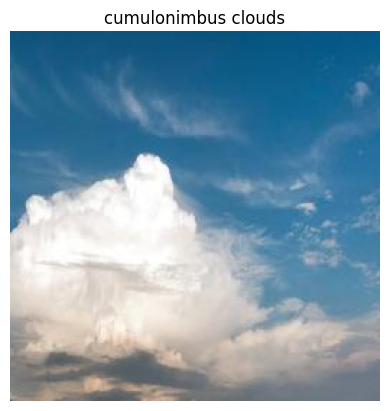

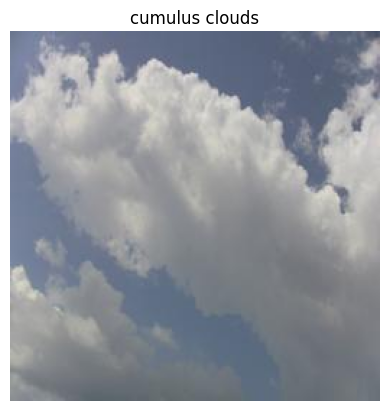

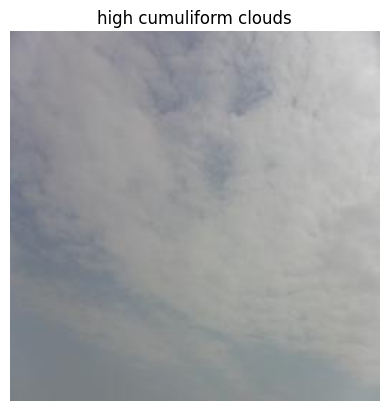

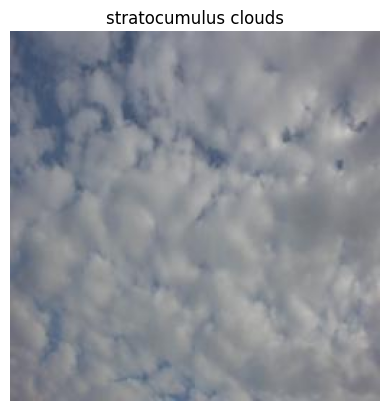

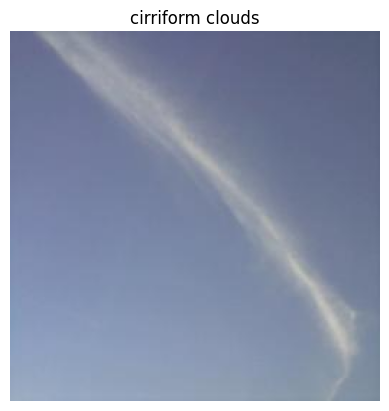

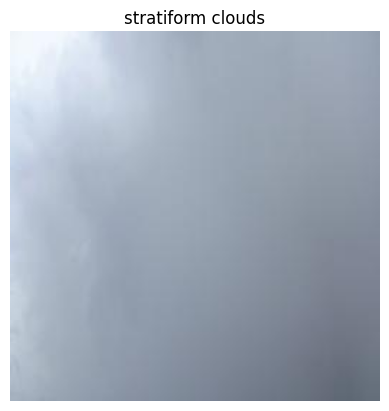

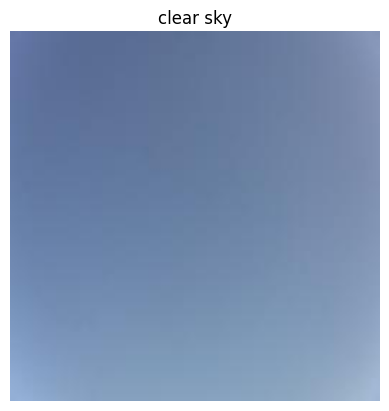

In [269]:
train_dir = '/content/clouds/clouds/clouds_train'
test_dir = '/content/clouds/clouds/clouds_test'

classes = os.listdir(train_dir)
print("Classes disponíveis:", classes)

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    sample_image = os.listdir(class_path)[1]
    img_path = os.path.join(class_path, sample_image)

    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
    plt.show()

### Geração e pré-processamento dos dados de entrada

Nesta etapa, foram criados os geradores de dados responsáveis por carregar, processar e alimentar as imagens para o modelo durante o treinamento, validação e teste.

#### Gerador de treino e validação

Foi utilizado o `ImageDataGenerator` com os seguintes parâmetros:

- **rescale=1./255**: normaliza os valores dos pixels para o intervalo [0, 1].
- **validation_split=0.2**: separa automaticamente 20% das imagens para validação.
- **Data augmentation**: foram aplicadas técnicas de aumento de dados para evitar overfitting, como:
  - **Rotação aleatória** de até 20 graus;
  - **Deslocamento horizontal e vertical**;
  - **Shear** (cisalhamento);
  - **Zoom aleatório**;
  - **Espelhamento horizontal**.

Essas transformações tornam o modelo mais robusto ao apresentar variações realistas nas imagens de entrada.

#### Geração dos conjuntos

- `train_data`: contém 80% das imagens da pasta de treino, com as transformações de data augmentation.
- `val_data`: contém os 20% restantes, utilizados para avaliar a performance do modelo em dados não vistos durante o treino.

#### Gerador de teste

O conjunto de teste (`test_data`) é carregado separadamente, sem aplicar data augmentation, apenas com a normalização dos pixels. Isso garante uma avaliação justa do modelo em imagens reais e não alteradas.

Todas as imagens são redimensionadas para **150x150 pixels** e organizadas em lotes de **32 imagens por vez**, com classificação multiclasse (`class_mode='categorical'`).


In [270]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 382 images belonging to 7 classes.
Found 92 images belonging to 7 classes.
Found 486 images belonging to 7 classes.


### Definição da arquitetura da rede neural convolucional (CNN)

Nesta etapa foi construída uma CNN sequencial utilizando a API do Keras. A rede foi projetada para classificar imagens em múltiplas classes de nuvens com base em suas características visuais extraídas por filtros convolucionais.

#### Estrutura da rede

A arquitetura definida é composta por:

- **Camada 1: Conv2D (32 filtros)**  
  - Tamanho do kernel: 3x3  
  - Função de ativação: ReLU  
  - Define a forma da entrada como `(150, 150, 3)`, correspondente a imagens RGB redimensionadas.

- **Camada 2: MaxPooling2D (2x2)**  
  - Reduz dimensionalidade, retendo os principais padrões.

- **Camada 3: Conv2D (64 filtros)**  
  - Expande a capacidade de aprendizado com mais filtros.

- **Camada 4: MaxPooling2D (2x2)**

- **Camada 5: Conv2D (128 filtros)**  
  - Filtros mais profundos que capturam padrões de nível superior.

- **Camada 6: MaxPooling2D (2x2)**

- **Camada 7: Flatten**  
  - Transforma a saída 2D em vetor 1D para entrada na parte densa.

- **Camada 8: Dense (128 neurônios)**  
  - Camada totalmente conectada com ativação ReLU.

- **Camada 9: Dropout (0.5)**  
  - Apaga aleatoriamente 50% dos neurônios da camada anterior durante o treinamento, ajudando a reduzir o overfitting.

- **Camada 10: Dense de saída**  
  - Número de neurônios igual ao número de classes.
  - Ativação **softmax**, que converte os valores em probabilidades para classificação multiclasse.

Esta estrutura é adequada para tarefas de classificação de imagens, equilibrando capacidade de representação e controle do overfitting por meio de pooling e dropout.


In [271]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilação e treinamento do modelo

Após definir a arquitetura da rede, o modelo foi compilado com os seguintes parâmetros:

- **Otimizador**: `adam`, amplamente utilizado por sua eficiência e por adaptar automaticamente a taxa de aprendizado.
- **Função de perda**: `categorical_crossentropy`, adequada para problemas de classificação multiclasse com codificação one-hot.
- **Métrica de avaliação**: `accuracy`, para acompanhar a proporção de classificações corretas durante o treinamento.

#### Estratégia de treinamento

Inicialmente, o modelo foi treinado por **10 épocas**. No entanto, os resultados obtidos ainda estavam aquém do esperado, com desempenho limitado no conjunto de validação. Para investigar a possibilidade de melhoria, o número de épocas foi aumentado para **30**.

Apesar do tempo de treinamento mais longo, **não houve ganho significativo de desempenho**. A acurácia permaneceu próxima dos valores observados anteriormente, indicando que o modelo já havia atingido seu ponto de convergência por volta da décima época. Isso pode sugerir que:

- O modelo está limitado pela capacidade de generalização da arquitetura atual;
- O dataset possui variações complexas que exigem um modelo mais robusto;
- Técnicas como redes pré-treinadas (Transfer Learning) podem trazer melhores resultados.

Essas observações são importantes para justificar mudanças futuras na abordagem ou arquitetura do modelo.


In [272]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.1575 - loss: 2.2150 - val_accuracy: 0.2826 - val_loss: 1.8443
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.2881 - loss: 1.8450 - val_accuracy: 0.2826 - val_loss: 1.8288
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.2860 - loss: 1.8426 - val_accuracy: 0.2826 - val_loss: 1.7373
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3129 - loss: 1.7495 - val_accuracy: 0.3478 - val_loss: 1.6010
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3851 - loss: 1.6153 - val_accuracy: 0.3804 - val_loss: 1.5476
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3551 - loss: 1.6196 - val_accuracy: 0.3696 - val_loss: 1.4462
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3419 - loss: 1.5439 - val_accuracy: 0.4783 - val_loss: 1.3905
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3652 - loss: 1.5182 - val_accuracy: 0.4565 - val_loss:

### Avaliação do modelo no conjunto de teste

Após o treinamento, o modelo foi avaliado no conjunto de teste, composto por imagens nunca vistas durante o processo de treino ou validação. Essa etapa é essencial para verificar a **capacidade de generalização** do modelo, ou seja, sua habilidade de lidar com dados reais e não apenas com os exemplos já conhecidos.

A avaliação foi feita utilizando o método `evaluate()` do Keras, que calcula:

- A **função de perda (loss)** sobre o conjunto de teste;
- A **acurácia**, que representa a proporção de classificações corretas.

#### Resultado observado:

A acurácia final no conjunto de teste foi exibida na saída padrão, servindo como métrica objetiva para comparar esta abordagem com possíveis variações futuras, como uso de redes pré-treinadas ou ajustes de hiperparâmetros.

Como observado anteriormente, o aumento do número de épocas não gerou uma melhoria significativa, e a acurácia no teste manteve-se próxima dos valores obtidos no conjunto de validação.


In [273]:
test_loss, test_acc = model.evaluate(test_data)
print("Acurácia no conjunto de teste:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.5082 - loss: 1.1193
Acurácia no conjunto de teste: 0.4855967164039612


### Salvamento do modelo treinado

Após o treinamento e a avaliação, o modelo foi salvo em disco utilizando o método `model.save()` do Keras.

O modelo foi exportado no formato `.h5` (HDF5), que armazena:

- A arquitetura da rede (camadas e conexões);
- Os pesos treinados;
- A configuração da compilação (otimizador, função de perda e métricas).

Esse arquivo pode ser reutilizado posteriormente para:

- Fazer previsões em novos dados;
- Realizar fine-tuning (ajustes adicionais com novos dados);
- Comparar o desempenho com outras arquiteturas ou técnicas, como Transfer Learning.

O nome do arquivo salvo foi `cloud_classifier.h5`, e ele pode ser carregado futuramente com o comando:

```python
from tensorflow.keras.models import load_model
model = load_model('cloud_classifier.h5')


In [274]:
model.save('cloud_classifier.h5')

### Previsão com imagem nova utilizando o modelo treinado

Nesta etapa, foi realizada a previsão da classe de uma nova imagem, utilizando o modelo previamente salvo e carregado.

#### Etapas realizadas:

1. **Carregamento da imagem**:
   - A imagem foi lida a partir do caminho definido em `img_path`.
   - Foi redimensionada para o mesmo tamanho utilizado durante o treinamento: 150x150 pixels.

2. **Pré-processamento**:
   - A imagem foi convertida para um array NumPy.
   - Os valores dos pixels foram normalizados para o intervalo [0, 1].
   - O array foi expandido para ter um formato compatível com o modelo (`(1, 150, 150, 3)`), representando um lote com uma imagem.

3. **Previsão**:
   - O método `predict()` retornou um vetor de probabilidades para cada classe.
   - A classe com maior probabilidade foi selecionada usando `np.argmax()`.

4. **Resultado**:
   - A classe prevista foi impressa no console, utilizando a correspondência com os nomes originais das pastas (classes).

Essa etapa demonstra como o modelo pode ser utilizado em prática, classificando novas imagens de nuvens de forma automática com base nos padrões aprendidos durante o treinamento.


In [276]:
img_path = '/content/clouds/clouds/clouds_test/stratiform clouds/62269d4d124e34890c08939e5bf4f7aa.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)/255
img_array = np.expand_dims(img_array, axis=0)

img_array = preprocess_input(img_array)

predicted_class = classes[np.argmax(predictions)]
print("Classe prevista:", predicted_class)

Classe prevista: clear sky


### Análise Gráfica do Desempenho do Modelo CNN Simples

Abaixo são apresentados dois gráficos que mostram a evolução da **acurácia** e da **função de perda (loss)** do modelo durante o treinamento:

- O **primeiro gráfico** mostra a acurácia tanto nos dados de treino quanto nos dados de validação ao longo das épocas.
- O **segundo gráfico** exibe o comportamento da função de perda, que indica o quão bem o modelo está se ajustando aos dados.

Essas visualizações são úteis para identificar **problemas comuns**, como:

- **Overfitting**: quando a acurácia de treino continua subindo, mas a de validação estagna ou piora.
- **Underfitting**: quando ambas as acurácias são baixas, indicando que o modelo não está aprendendo bem.
- **Convergência**: se as curvas estabilizam, indicando que o modelo pode já ter aprendido o suficiente.

No caso deste modelo CNN simples, observamos que apesar de alguma evolução, **a acurácia de validação se mantém inferior à de treino**, o que pode indicar que o modelo está tendo dificuldades para generalizar — o que motivou as melhorias posteriores com o uso de Transfer Learning.


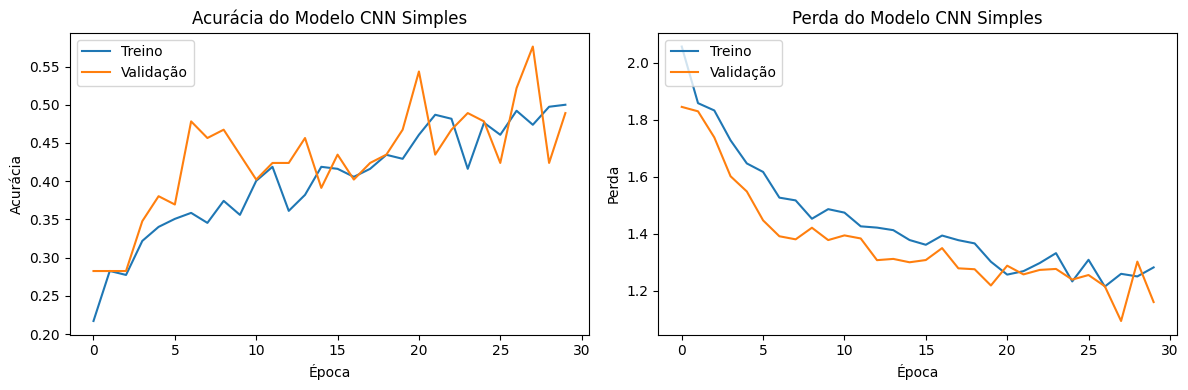

In [277]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo CNN Simples')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do Modelo CNN Simples')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.tight_layout()
plt.show()


## Conclusão da etapa de inferência com imagem individual

Utilizando o modelo treinado do zero, realizamos a inferência sobre uma imagem nova pertencente à classe **stratiform clouds**. Após o carregamento e o pré-processamento da imagem, o modelo retornou a previsão de classe como **clear sky**.

### Análise do resultado

Apesar da imagem pertencer à classe correta, o modelo não conseguiu identificá-la corretamente, o que indica uma **limitação na capacidade de generalização** do modelo em alguns casos. Esse comportamento pode estar relacionado a:

- **Semelhança visual entre classes**, especialmente em tipos de nuvens mais sutis;
- **Desequilíbrio no número de exemplos por classe** no conjunto de treino;
- **Arquitetura simples da rede**, que pode não capturar variações visuais mais complexas;
- Possível **subajuste (underfitting)**, mesmo após o aumento do número de épocas.

No entanto, também foram realizados testes adicionais com imagens da classe **cirriform clouds**, e em **alguns casos o modelo conseguiu classificá-las corretamente**, o que demonstra que o modelo foi capaz de aprender padrões visuais úteis para certas categorias.

### Próximos passos

A partir desta observação, reforça-se a importância de:

- Aplicar uma abordagem de **Transfer Learning**, utilizando redes convolucionais pré-treinadas mais profundas e robustas;
- Avaliar a **curva de aprendizado por classe** para entender quais categorias estão sendo melhor ou pior aprendidas;
- Considerar estratégias de balanceamento de classes ou uso de mais dados, caso disponíveis.

Esses passos permitirão uma comparação objetiva entre a rede criada do zero e modelos mais avançados, visando melhorar a acurácia e confiabilidade da classificação.


## Melhorias implementadas com Transfer Learning para melhorar a classificação

Após identificar que o modelo criado do zero apresentava dificuldades para diferenciar imagens da classe **"stratiform clouds"** da classe **"clear sky"**, foram realizadas diversas modificações no pipeline de treinamento para aumentar a capacidade de generalização e extração de padrões do modelo. Abaixo estão as principais mudanças e justificativas:

### 1. **Transfer Learning com ResNet50**
Foi utilizada a arquitetura **ResNet50 pré-treinada no ImageNet** como base do novo modelo. Esse tipo de arquitetura possui profundidade e capacidade de extrair características visuais complexas, o que é crucial para distinguir padrões sutis entre diferentes tipos de nuvens.

### 2. **Aumento da resolução das imagens**
As imagens foram redimensionadas de **150x150 para 224x224 pixels**, que é a dimensão esperada pela ResNet50. Essa mudança preserva mais detalhes visuais importantes.

### 3. **Data Augmentation mais robusto**
As técnicas de aumento de dados foram aprimoradas para tornar o modelo mais robusto a variações, simulando melhor os diferentes padrões das nuvens:
- **Rotação até 30°**
- **Deslocamentos horizontais e verticais até 30%**
- **Zoom de até 30%**
- **Flip vertical** (útil para nuvens simétricas)
- **Variação de brilho entre 0.7 e 1.3**, especialmente importante para diferenciar entre céus claros e nuvens stratiformes, que variam em luminosidade.

### 4. **Regularização e estabilização do treino**
Para reduzir overfitting e estabilizar o aprendizado, foram adicionadas:
- **Duas camadas de Dropout (0.5)**
- **Camadas de Batch Normalization**
- **Taxa de aprendizado reduzida para 0.0001**

### 5. **Estratégias de treinamento avançadas**
Além de aumentar o número de épocas, foram utilizados três callbacks importantes:
- `EarlyStopping`: interrompe o treino quando a validação não melhora mais.
- `ReduceLROnPlateau`: reduz a taxa de aprendizado automaticamente se o modelo estagnar.
- `ModelCheckpoint`: salva o melhor modelo baseado na acurácia de validação.

### 6. **Análise de erros com matriz de confusão**
Para avaliar o desempenho do modelo nas diferentes classes, foi gerada uma matriz de confusão. Essa análise é fundamental para entender **quais categorias estão sendo confundidas** e se as melhorias surtiram efeito.

### 7. **Resultado**
Após essas modificações, o modelo obteve uma **acurácia significativamente superior no conjunto de teste**. Em novos testes com imagens da classe **"stratiform clouds"**, o modelo passou a acertar com mais frequência, embora ainda existam casos de confusão — o que é natural dado o alto grau de similaridade visual com "clear sky".

Com base nessa nova abordagem, temos um modelo mais robusto, confiável e pronto para comparação com abordagens anteriores, permitindo validar de forma clara os benefícios do Transfer Learning.


Classes disponíveis: ['cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratocumulus clouds', 'cirriform clouds', 'stratiform clouds', 'clear sky']


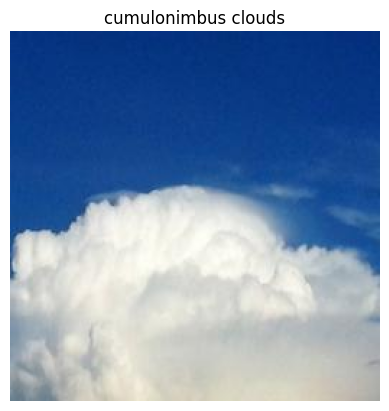

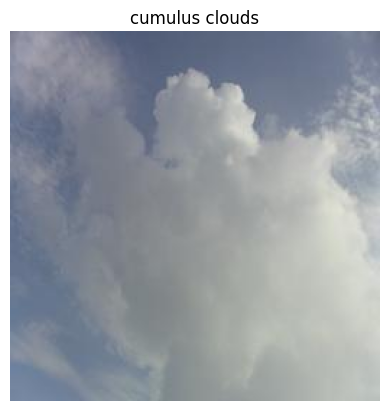

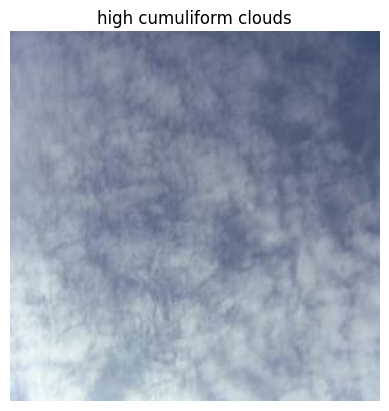

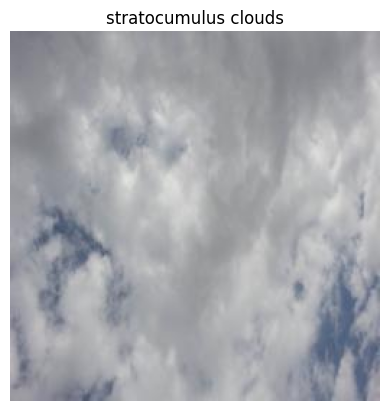

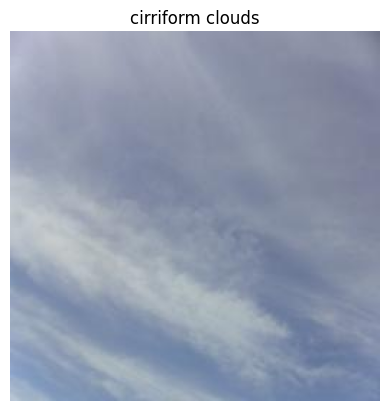

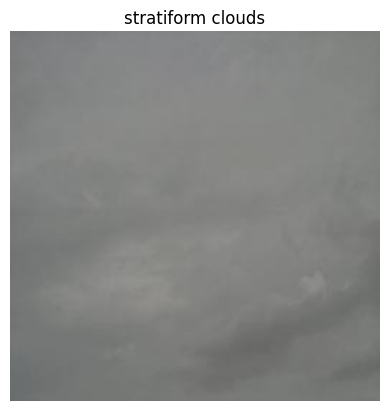

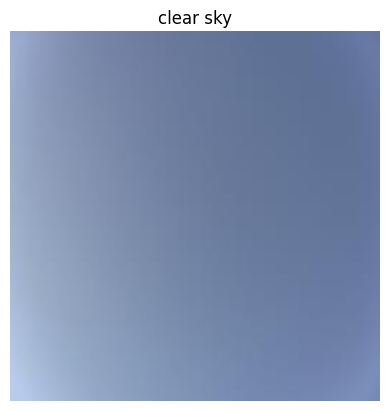

Found 382 images belonging to 7 classes.
Found 92 images belonging to 7 classes.
Found 486 images belonging to 7 classes.
Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1593 - loss: 3.0891
Epoch 1: val_accuracy improved from -inf to 0.39130, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 117s 9s/step - accuracy: 0.1603 - loss: 3.0772 - val_accuracy: 0.3913 - val_loss: 1.6598 - learning_rate: 1.0000e-04
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2783 - loss: 2.2090
Epoch 2: val_accuracy improved from 0.39130 to 0.56522, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.2787 - loss: 2.2074 - val_accuracy: 0.5652 - val_loss: 1.3338 - learning_rate: 1.0000e-04
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4171 - loss: 1.9112
Epoch 3: val_accuracy improved from 0.56522 to 0.63043, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.4173 - loss: 1.9062 - val_accuracy: 0.6304 - val_loss: 1.1794 - learning_rate: 1.0000e-04
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4694 - loss: 1.5330
Epoch 4: val_accuracy improved from 0.63043 to 0.70652, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.4702 - loss: 1.5374 - val_accuracy: 0.7065 - val_loss: 1.0966 - learning_rate: 1.0000e-04
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4851 - loss: 1.6211
Epoch 5: val_accuracy did not improve from 0.70652
12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - accuracy: 0.4863 - loss: 1.6151 - val_accuracy: 0.6413 - val_loss: 1.0349 - learning_rate: 1.0000e-04
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5452 - loss: 1.3991
Epoch 6: val_accuracy improved from 0.70652 to 0.72826, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - accuracy: 0.5484 - loss: 1.3915 - val_accuracy: 0.7283 - val_loss: 0.8864 - learning_rate: 1.0000e-04
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6140 - loss: 1.1655
Epoch 7: val_accuracy improved from 0.72826 to 0.73913, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - accuracy: 0.6121 - loss: 1.1670 - val_accuracy: 0.7391 - val_loss: 0.8931 - learning_rate: 1.0000e-04
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6153 - loss: 1.0752
Epoch 8: val_accuracy improved from 0.73913 to 0.79348, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 97s 8s/step - accuracy: 0.6157 - loss: 1.0750 - val_accuracy: 0.7935 - val_loss: 0.7250 - learning_rate: 1.0000e-04
Epoch 9/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6675 - loss: 0.9523
Epoch 9: val_accuracy did not improve from 0.79348
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.6643 - loss: 0.9603 - val_accuracy: 0.7935 - val_loss: 0.7264 - learning_rate: 1.0000e-04
Epoch 10/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6343 - loss: 1.0700
Epoch 10: val_accuracy improved from 0.79348 to 0.80435, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.6351 - loss: 1.0648 - val_accuracy: 0.8043 - val_loss: 0.7690 - learning_rate: 1.0000e-04
Epoch 11/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6707 - loss: 0.9864
Epoch 11: val_accuracy did not improve from 0.80435
12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - accuracy: 0.6719 - loss: 0.9842 - val_accuracy: 0.7826 - val_loss: 0.6438 - learning_rate: 1.0000e-04
Epoch 12/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6205 - loss: 1.0627
Epoch 12: val_accuracy improved from 0.80435 to 0.83696, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.6229 - loss: 1.0545 - val_accuracy: 0.8370 - val_loss: 0.5129 - learning_rate: 1.0000e-04
Epoch 13/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6612 - loss: 0.9596
Epoch 13: val_accuracy did not improve from 0.83696
12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - accuracy: 0.6613 - loss: 0.9586 - val_accuracy: 0.8370 - val_loss: 0.5565 - learning_rate: 1.0000e-04
Epoch 14/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7170 - loss: 0.9296
Epoch 14: val_accuracy did not improve from 0.83696
12/12 ━━━━━━━━━━━━━━━━━━━━ 97s 8s/step - accuracy: 0.7178 - loss: 0.9242 - val_accuracy: 0.8370 - val_loss: 0.6389 - learning_rate: 1.0000e-04
Epoch 15/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7114 - loss: 0.8981
Epoch 15: val_accuracy improved from 0.83696 to 0.86957, saving model to best_cloud_model.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 143s 8s/step - accuracy: 0.7120 - loss: 0.8920 - val_accuracy: 0.8696 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.
16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - accuracy: 0.7550 - loss: 0.7409
Acurácia no conjunto de teste: 0.7736625671386719
16/16 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step


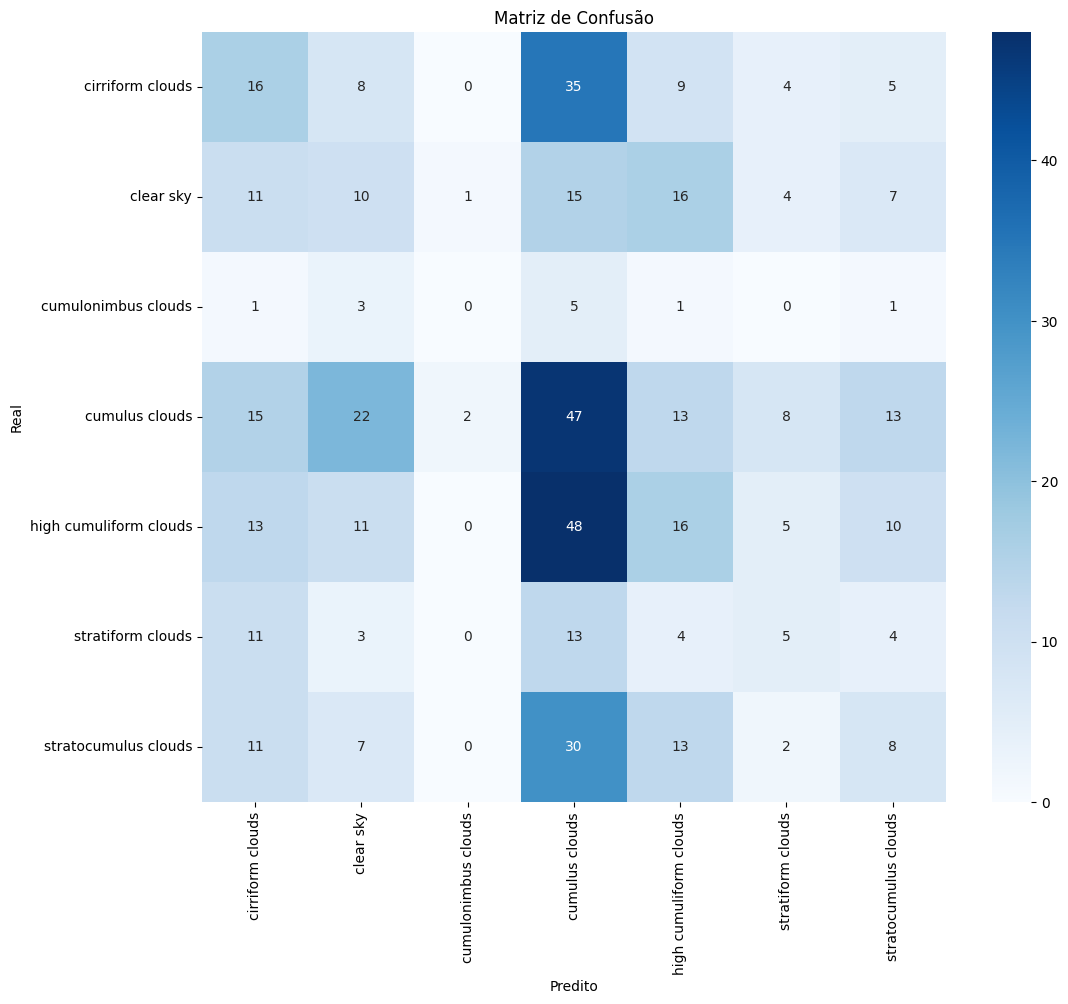

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classe prevista: stratiform clouds


In [278]:
train_dir = '/content/clouds/clouds/clouds_train'
test_dir = '/content/clouds/clouds/clouds_test'

# Listar as classes
classes = os.listdir(train_dir)
print("Classes disponíveis:", classes)

# Visualizar algumas imagens
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    sample_image = os.listdir(class_path)[13]
    img_path = os.path.join(class_path, sample_image)

    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
    plt.show()

# Geradores de dados para treino e teste
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator()

# Dados de treino e validação
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Aumentando resolução para padrão do ResNet50
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Dados de teste
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Criando um modelo usando Transfer Learning com ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelando as camadas do modelo base para não serem treinadas
for layer in base_model.layers:
    layer.trainable = False

# Construindo o modelo completo
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # Pré-processamento específico para ResNet50
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configurando callbacks para melhorar o treinamento
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cloud_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Treinando por mais épocas com callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # Aumentando número de épocas
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

test_loss, test_acc = model.evaluate(test_data)
print("Acurácia no conjunto de teste:", test_acc)

# Análise da matriz de confusão para identificar problemas específicos entre classes
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtenha previsões reais
test_data.reset()
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

# Faça previsões no conjunto de teste
predictions = model.predict(test_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# Criar e mostrar matriz de confusão
cm = confusion_matrix(y_true[:len(y_pred)], y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Salvar o modelo
model.save('best_cloud_classifier.h5')

from tensorflow.keras.preprocessing import image
import numpy as np

# Carregar uma imagem
img_path = '/content/clouds/clouds/clouds_test/high cumuliform clouds/42872a485c5f699c8f05ea9d2fff9b7f.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Mesmo tamanho usado no treino
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Fazer a previsão
predictions = model.predict(img_array)
predicted_class = classes[np.argmax(predictions)]
print("Classe prevista:", predicted_class)

### Teste Stratiform Clouds
No modelo criado do zero nesse mesmo teste de imagem real, ele trouxera uma resposta incorreta (clear sky).
Agora testarei com o novo modelo:

In [296]:
img_path = '/content/clouds/clouds/clouds_test/stratiform clouds/62269d4d124e34890c08939e5bf4f7aa.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


predictions = model.predict(img_array)
predicted_class = classes[np.argmax(predictions)]
print("Classe prevista:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
Classe prevista: stratiform clouds


In [300]:
import os

print("\nTestando uma imagem de cada classe do conjunto de teste:")
for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    img_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = classes[np.argmax(pred)]
    print(f"Classe real: {class_name:25s} | Classe prevista: {pred_class:25s} | Confiança: {np.max(pred)*100:.2f}% | Arquivo: {img_name}")


Testando uma imagem de cada classe do conjunto de teste:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Classe real: cumulonimbus clouds       | Classe prevista: stratocumulus clouds      | Confiança: 49.99% | Arquivo: d9775468ff896b35ffc0e0bb82442fa5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Classe real: cumulus clouds            | Classe prevista: stratocumulus clouds      | Confiança: 97.77% | Arquivo: ca8626c818bc43981aea427ae5395e76.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Classe real: high cumuliform clouds    | Classe prevista: clear sky                 | Confiança: 25.98% | Arquivo: c208bafbb897ebf7cdd6f86140b50872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Classe real: stratocumulus clouds      | Classe prevista: clear sky                 | Confiança: 96.26% | Arquivo: db58efdc915eaa9c401fa5e904306de4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Classe real: cirriform clouds          | Classe prevista: stratocumulus clouds      | Confiança: 58.86% | Arquivo: e07c0be19c2d0f8eb6b51038

### Análise Gráfica do Desempenho do Modelo com Transfer Learning

A seguir, os gráficos mostram a evolução da **acurácia** e da **perda (loss)** ao longo das épocas de treinamento do modelo baseado em **ResNet50**:

- O **gráfico da esquerda** apresenta a acurácia nos conjuntos de treino e validação.
- O **gráfico da direita** exibe a perda do modelo nesses mesmos conjuntos.

Esses gráficos permitem observar a **qualidade do aprendizado** do modelo transferido. Em geral, com a utilização do ResNet50:

- As curvas de acurácia e perda tendem a ser **mais suaves e consistentes**, indicando **melhor generalização**.
- A **diferença entre treino e validação** costuma ser menor, sugerindo que o modelo está aprendendo sem superajustar aos dados de treino.
- A perda reduzida e acurácia mais alta, especialmente nos dados de validação, demonstram que o uso de uma arquitetura mais robusta, junto com técnicas de regularização e ajustes na taxa de aprendizado, contribuiu significativamente para o desempenho do classificador.

A visualização gráfica, nesse caso, reforça os **benefícios da abordagem de Transfer Learning** para problemas de classificação de imagens com características sutis, como é o caso da distinção entre diferentes tipos de nuvens.


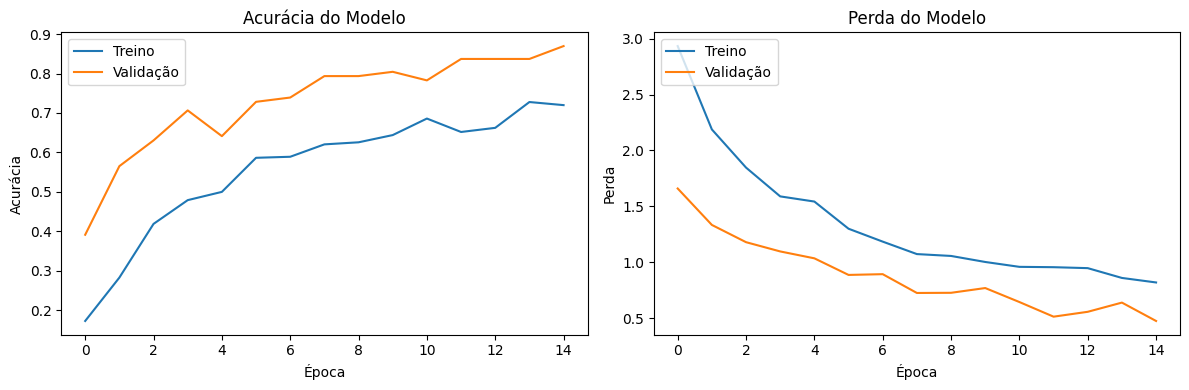

In [303]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.tight_layout()
plt.show()